In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd

from harp_resources import process, utils
from scipy.signal import savgol_filter
import matplotlib.patches as patches

In [2]:
data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_220824/2024-08-22T13-13-15_B3M6')
photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_220824/photometry/B3M6_MMclosed&Regular_day1/2024_08_22-15_16_40')

In [3]:
def moving_average_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

def running_unit_conversion(running_array):
    resolution = 12000 # counts per inch
    inches_per_count = 1 / resolution
    meters_per_count = 0.0254 * inches_per_count
    dt = 0.01 # for OpticalTrackingRead0Y(46)
    linear_velocity = meters_per_count / dt # meters per second per count
    
    # ball_radius = 0.1 # meters 
    # angular_velocity = linear_velocity / ball_radius # radians per second per count
    # angular_velocity = angular_velocity * (180 / np.pi) # degrees per second per count
    # print(angular_velocity)
    
    return running_array * linear_velocity * 100

In [4]:
preprocessed_csv = pd.read_csv('/home/ikharitonov/Downloads/preprocessed_grab.csv')
preprocessed_csv['TimeStamp'] = preprocessed_csv['TimeStamp'] * 1000
preprocessed_csv

,TimeStamp,470_dfF,560_dfF,410_dfF,z_470,z_560,z_410,Time,mouseID,Area,Sex,Input1_event
0,15033.331,0.491156,0.161129,0.223027,1.028995,1.885576,0.395709,2024-08-22 15:16:55.033331,B3M6,V2M,F,False
1,15133.328,0.460083,0.148091,0.175104,0.964737,1.729241,0.311359,2024-08-22 15:16:55.133328,B3M6,V2M,F,False
2,15233.331,0.429796,0.135409,0.128612,0.902106,1.577183,0.229533,2024-08-22 15:16:55.233331,B3M6,V2M,F,False
3,15333.333,0.400508,0.123453,0.084386,0.841541,1.433834,0.151701,2024-08-22 15:16:55.333333,B3M6,V2M,F,False
4,15433.330,0.372381,0.112435,0.043178,0.783376,1.301734,0.079185,2024-08-22 15:16:55.433330,B3M6,V2M,F,False
...,...,...,...,...,...,...,...,...,...,...,...,...
19095,1924276.589,-0.593072,-0.284968,-0.802906,-1.206391,-3.292858,-1.299677,2024-08-22 15:48:44.276589,B3M6,V2M,F,False
19096,1924376.574,-0.640253,-0.300625,-0.838024,-1.303423,-3.471251,-1.356663,2024-08-22 15:48:44.376574,B3M6,V2M,F,False
19097,1924476.561,-0.689359,-0.316688,-0.874687,-1.404415,-3.654267,-1.416155,2024-08-22 15:48:44.476561,B3M6,V2M,F,False
19098,1924576.550,-0.738855,-0.332665,-0.911412,-1.506207,-3.836295,-1.475749,2024-08-22 15:48:44.576550,B3M6,V2M,F,False


In [5]:
streams = utils.load_registers(data_path)

Dataset 2024-08-22T13-13-15_B3M6 contains following registers:
H1: [33, 32, 46]
H2: [39, 42]
Registers loaded in 2.34 seconds.


In [6]:
conversions = process.calculate_conversions_second_approach(data_path, photometry_path, verbose=False)

OnixAnalogClock loaded in 0.80 seconds.
Calculation of conversions finished in 11.92 seconds.


In [7]:
conversions.keys()

dict_keys(['onix_to_harp_timestamp', 'harp_to_onix_clock', 'photometry_to_harp_time', 'onix_time_to_photometry'])

In [8]:
preprocessed_csv['HARP Timestamps'] = conversions['photometry_to_harp_time'](preprocessed_csv['TimeStamp'])
preprocessed_csv['HARP Seconds'] = process.convert_datetime_to_seconds(preprocessed_csv['HARP Timestamps'])
preprocessed_csv

,TimeStamp,470_dfF,560_dfF,410_dfF,z_470,z_560,z_410,Time,mouseID,Area,Sex,Input1_event,HARP Timestamps,HARP Seconds
0,15033.331,0.491156,0.161129,0.223027,1.028995,1.885576,0.395709,2024-08-22 15:16:55.033331,B3M6,V2M,F,False,1904-01-05 02:08:54.500987493,353334.500987
1,15133.328,0.460083,0.148091,0.175104,0.964737,1.729241,0.311359,2024-08-22 15:16:55.133328,B3M6,V2M,F,False,1904-01-05 02:08:54.600985789,353334.600985
2,15233.331,0.429796,0.135409,0.128612,0.902106,1.577183,0.229533,2024-08-22 15:16:55.233331,B3M6,V2M,F,False,1904-01-05 02:08:54.700990084,353334.700990
3,15333.333,0.400508,0.123453,0.084386,0.841541,1.433834,0.151701,2024-08-22 15:16:55.333333,B3M6,V2M,F,False,1904-01-05 02:08:54.800993379,353334.800993
4,15433.330,0.372381,0.112435,0.043178,0.783376,1.301734,0.079185,2024-08-22 15:16:55.433330,B3M6,V2M,F,False,1904-01-05 02:08:54.900991675,353334.900991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19095,1924276.589,-0.593072,-0.284968,-0.802906,-1.206391,-3.292858,-1.299677,2024-08-22 15:48:44.276589,B3M6,V2M,F,False,1904-01-05 02:40:43.768977223,355243.768977
19096,1924376.574,-0.640253,-0.300625,-0.838024,-1.303423,-3.471251,-1.356663,2024-08-22 15:48:44.376574,B3M6,V2M,F,False,1904-01-05 02:40:43.868963518,355243.868963
19097,1924476.561,-0.689359,-0.316688,-0.874687,-1.404415,-3.654267,-1.416155,2024-08-22 15:48:44.476561,B3M6,V2M,F,False,1904-01-05 02:40:43.968951814,355243.968951
19098,1924576.550,-0.738855,-0.332665,-0.911412,-1.506207,-3.836295,-1.475749,2024-08-22 15:48:44.576550,B3M6,V2M,F,False,1904-01-05 02:40:44.068942109,355244.068942


In [9]:
OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
OnixAnalogData = utils.read_OnixAnalogData(data_path, binarise=True)

OnixAnalogClock loaded in 0.84 seconds.
OnixAnalogData loaded in 35.64 seconds.


In [10]:
print('Photodiode start', conversions['onix_to_harp_timestamp'](OnixAnalogClock[0]))
print('Photodiode stop', conversions['onix_to_harp_timestamp'](OnixAnalogClock[-1]))
print('Photometry start', preprocessed_csv['HARP Timestamps'].iloc[0])
print('Photometry stop', preprocessed_csv['HARP Timestamps'].iloc[-1])

Photodiode start 1904-01-05 02:08:51.182511
Photodiode stop 1904-01-05 02:40:37.680410
Photometry start 1904-01-05 02:08:54.500987493
Photometry stop 1904-01-05 02:40:44.168925404


In [11]:
ExperimentEvents = utils.read_ExperimentEvents(data_path)
ExperimentEvents

,Seconds,Value
0,353335.898784,Sync signal started
1,353343.348576,LinearNormal block started
2,353343.448544,Homing platform
3,353344.010240,Wait for run threshold...
4,353366.840256,Check halt probability
...,...,...
1212,355218.460256,Wait for run threshold...
1213,355228.040256,Check halt probability
1214,355228.040256,No halt
1215,355228.040256,Wait for run threshold...


In [12]:
ExperimentEvents.Value.unique()

array(['Sync signal started', 'LinearNormal block started',
       'Homing platform', 'Wait for run threshold...',
       'Check halt probability', 'No halt', 'Block timer elapsed',
       'LinearRegularMismatch block started', 'Halt delay: 1s',
       'Apply halt: 1s', 'LinearMismatch block started'], dtype=object)

In [13]:
ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s']

,Seconds,Value
70,353974.110272,Apply halt: 1s
74,353976.850240,Apply halt: 1s
78,353979.370240,Apply halt: 1s
82,353981.810240,Apply halt: 1s
86,353984.309792,Apply halt: 1s
...,...,...
1165,355031.530240,Apply halt: 1s
1175,355068.830240,Apply halt: 1s
1182,355093.280256,Apply halt: 1s
1189,355121.330240,Apply halt: 1s


In [14]:
ExperimentEvents[ExperimentEvents.Value=='LinearMismatch block started']

,Seconds,Value
1044,354601.600256,LinearMismatch block started


In [41]:
# A = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[0].Seconds
# B = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[-1].Seconds

# A = ExperimentEvents.iloc[0].Seconds
# B = ExperimentEvents.iloc[-1].Seconds

A = ExperimentEvents[ExperimentEvents.Value=='LinearMismatch block started'].iloc[0].Seconds
B = ExperimentEvents.iloc[-1].Seconds

# A = 354900
# B = A+200

print(A, B)
print(process.convert_seconds_to_datetime(A), process.convert_seconds_to_datetime(B))

354601.600256 355229.800832
1904-01-05 02:30:01.600256 1904-01-05 02:40:29.800832


In [42]:
selected_harp_times, selected_photodiode_data = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, A, B, conversions)

Selection of photodiode data finished in 20.56 seconds.


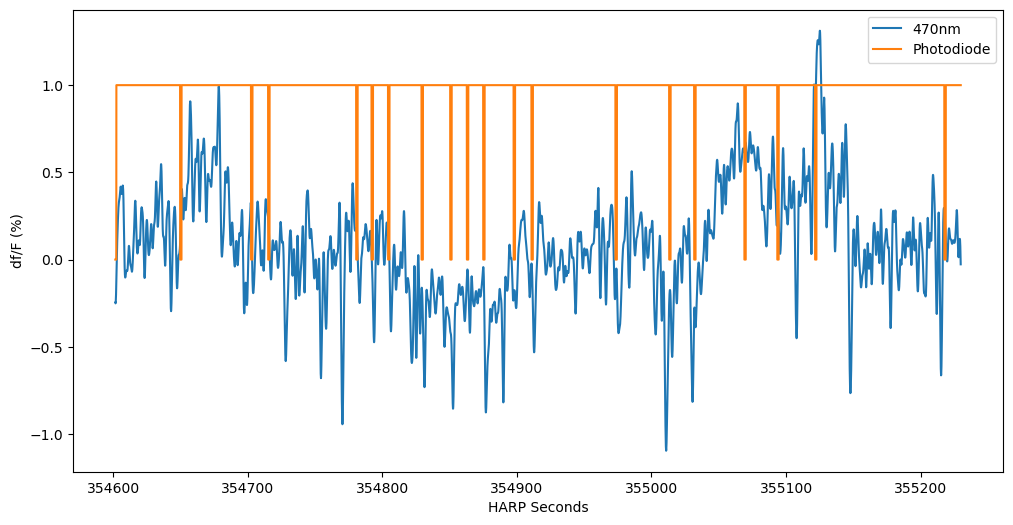

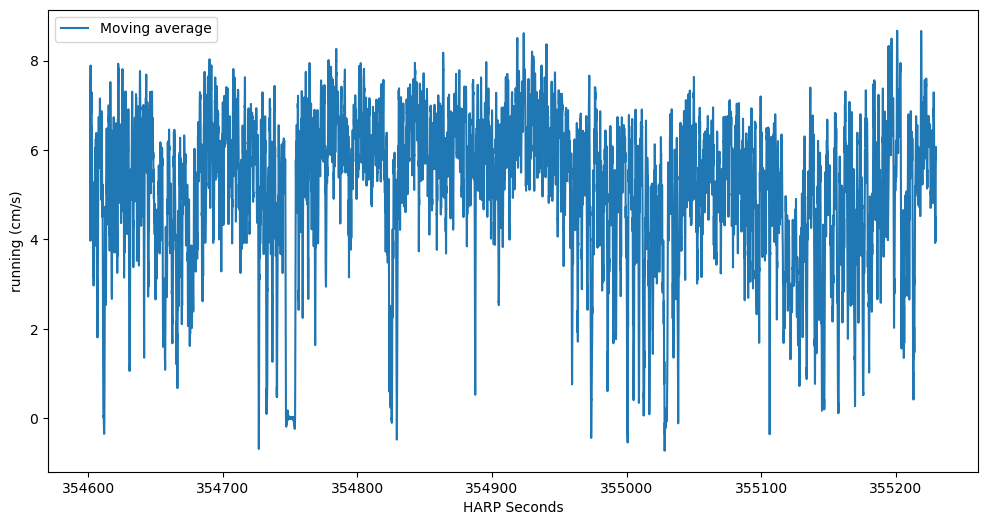

In [43]:
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))

plt.figure(figsize=(12,6))
plt.plot(preprocessed_csv[preprocessed_csv['HARP Seconds'].between(A, B)]['HARP Seconds'], preprocessed_csv[preprocessed_csv['HARP Seconds'].between(A, B)]['470_dfF'], label='470nm')

t = (selected_harp_times - utils.harp.REFERENCE_EPOCH).total_seconds()
plt.plot(t, selected_photodiode_data[:,0], label='Photodiode')
plt.xlabel('HARP Seconds')
plt.ylabel('df/F (%)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
# running in cm/s
y1 = streams['H1']['OpticalTrackingRead0X(46)'].loc[process.convert_seconds_to_datetime(A):process.convert_seconds_to_datetime(B)]
y1 = running_unit_conversion(y1)
t = (y1.index - utils.harp.REFERENCE_EPOCH).total_seconds()
# y2 = savgol_filter(y1, 50, 3)
y3 = moving_average_smoothing(y1, 50)
# plt.plot(t, y1, label='Raw running')
# plt.plot(t, y2, label='Savgol')
plt.plot(t, y3, label='Moving average')
plt.legend()
plt.xlabel('HARP Seconds')
plt.ylabel('running (cm/s)')
plt.show()

## halt time analysis

In [44]:
t = (selected_harp_times - utils.harp.REFERENCE_EPOCH).total_seconds()
t

Index([354601.600264189, 354601.600274203,  354601.60028421, 354601.600294244,
       354601.600304262, 354601.600314269, 354601.600324295, 354601.600334321,
       354601.600344328, 354601.600354346,
       ...
       355229.800736612, 355229.800746642, 355229.800756648, 355229.800766663,
       355229.800776693, 355229.800786707, 355229.800796718, 355229.800806748,
       355229.800816762, 355229.800826769],
      dtype='float64', length=62705063)

In [45]:
photodiode_low_state_times = t[np.where(selected_photodiode_data[:,0]==0)].to_numpy()
intervals_between_states = np.diff(photodiode_low_state_times)
print(photodiode_low_state_times)
print(intervals_between_states)
print(photodiode_low_state_times.shape, intervals_between_states.shape)

[354601.60026419 354601.6002742  354601.60028421 ... 355218.61993979
 355218.61995982 355218.61997986]
[1.00139878e-05 1.00070029e-05 1.00340112e-05 ... 1.00299949e-05
 2.00250070e-05 2.00399663e-05]
(2065330,) (2065329,)


[2.06531e+06 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 3.00000e+00
 2.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00
 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.

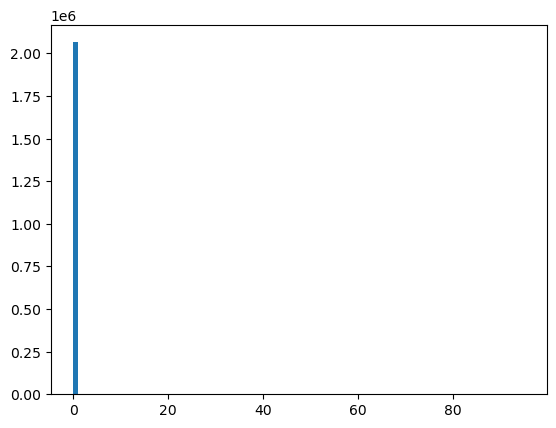

In [46]:
# Checking what are the differences between the time values that we selected are (those corresponding to low states of photodiode)
counts, intervals, _ = plt.hist(intervals_between_states, bins=100)
print(counts)
print(intervals)

In [47]:
# low many values there are in the smallest interval
counts[0]

2065310.0

In [48]:
# mean of differences plus two standard deviations
threshold = intervals_between_states.mean() + 1 * intervals_between_states.std()
threshold

0.11770875814167048

In [49]:
intervals_between_states[np.where(intervals_between_states < threshold)]

array([1.00139878e-05, 1.00070029e-05, 1.00340112e-05, ...,
       1.00299949e-05, 2.00250070e-05, 2.00399663e-05])

In [50]:
print(f'The number of values in the first interval [{intervals[0]}, {intervals[1]}] = {counts[0]} == the number of difference values between halt occurrences < chosen threshold {threshold} = {intervals_between_states[np.where(intervals_between_states < threshold)].shape[0]} ==> {counts[0]==intervals_between_states[np.where(intervals_between_states < threshold)].shape[0]}')

The number of values in the first interval [9.929994121193886e-06, 0.9503256161336321] = 2065310.0 == the number of difference values between halt occurrences < chosen threshold 0.11770875814167048 = 2065310 ==> True


In [51]:
intervals_between_states[np.where(intervals_between_states >= threshold)]

array([47.39849456, 51.63194405, 11.6656644 , 64.36507246, 10.36568473,
       11.21576083, 23.83228582, 20.29905812, 11.29908337, 11.09894699,
       21.56565667, 12.19900069, 61.36516104, 38.83220368, 17.515643  ,
       36.23206402, 23.39883235, 27.01549278, 95.03157854])

In [52]:
# Selecting the indices where there are large time gaps between low states of photodiode (which are disconnected - distinct halts)
inds = np.where(intervals_between_states >= threshold)[0] + 1
inds

array([  72459,  177345,  282232,  387126,  492021,  596910,  701792,
        803345,  908225, 1013122, 1116350, 1221238, 1326125, 1434333,
       1539221, 1645778, 1750669, 1857227, 1960444])

In [53]:
# Getting the HARP second values for these halt beginning events
halt_times = photodiode_low_state_times[inds]
halt_times

array([354649.72477775, 354702.40763553, 354715.12410346, 354780.54010968,
       354791.9566781 , 354804.22327252, 354829.10635185, 354850.42284242,
       354862.77263915, 354874.92250989, 354897.52237972, 354910.77220398,
       354973.18822866, 355013.10450677, 355031.67098334, 355068.97062159,
       355093.42033763, 355121.50347478, 355217.5691062 ])

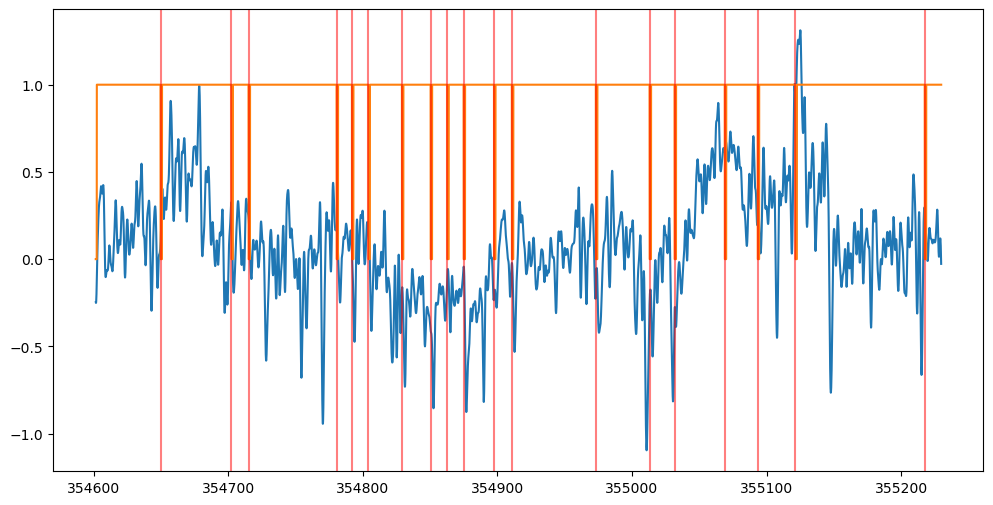

In [54]:
# Doing a visual check the detected halt time correspond to the photodiode trace
plt.figure(figsize=(12,6))
plt.plot(preprocessed_csv[preprocessed_csv['HARP Seconds'].between(A, B)]['HARP Seconds'], preprocessed_csv[preprocessed_csv['HARP Seconds'].between(A, B)]['470_dfF'])

t = (selected_harp_times - utils.harp.REFERENCE_EPOCH).total_seconds()
plt.plot(t, selected_photodiode_data[:,0])

for halt_time in halt_times:
    plt.axvline(halt_time, c='r', alpha=0.5)

plt.show()

## block average F0 analysis

In [55]:
def select_segment(trace, time_column_name, start, end):
    return trace[trace[time_column_name].between(start, end)]

def get_perievent_trace(trace, time_column_name, event_time, before_event_period=5, during_event_period=1, after_event_period=5):
    pre_event_time = event_time - before_event_period
    after_event_time = event_time + during_event_period + after_event_period
    return select_segment(trace, time_column_name, pre_event_time, after_event_time)

def dfF(trace, F0):
    return (trace - F0) / F0

In [56]:
ExperimentEvents.Value.unique()

array(['Sync signal started', 'LinearNormal block started',
       'Homing platform', 'Wait for run threshold...',
       'Check halt probability', 'No halt', 'Block timer elapsed',
       'LinearRegularMismatch block started', 'Halt delay: 1s',
       'Apply halt: 1s', 'LinearMismatch block started'], dtype=object)

In [57]:
temp_df = ExperimentEvents[ExperimentEvents.Value.isin(['LinearNormal block started', 'LinearRegularMismatch block started', 'LinearMismatch block started'])]
temp_df

,Seconds,Value
1,353343.348576,LinearNormal block started
65,353972.170240,LinearRegularMismatch block started
1044,354601.600256,LinearMismatch block started


In [58]:
block1_start = preprocessed_csv['HARP Seconds'].iloc[0]
block2_start = temp_df.iloc[1]['Seconds']
block3_start = temp_df.iloc[2]['Seconds']
block3_end = preprocessed_csv['HARP Seconds'].iloc[-1]

print(block1_start, block2_start, block3_start, block3_end)

353334.500987 353972.17024 354601.600256 355244.168925


In [59]:
temp_data = preprocessed_csv[['HARP Seconds','470_dfF']]
block1_average_dfF = select_segment(temp_data, 'HARP Seconds', block1_start, block2_start)['470_dfF'].mean()
block1_std_dfF = select_segment(temp_data, 'HARP Seconds', block1_start, block2_start)['470_dfF'].std()
block2_average_dfF = select_segment(temp_data, 'HARP Seconds', block2_start, block3_start)['470_dfF'].mean()
block2_std_dfF = select_segment(temp_data, 'HARP Seconds', block2_start, block3_start)['470_dfF'].std()
block3_average_dfF = select_segment(temp_data, 'HARP Seconds', block3_start, block3_end)['470_dfF'].mean()
block3_std_dfF = select_segment(temp_data, 'HARP Seconds', block3_start, block3_end)['470_dfF'].std()

print('block1 mean', block1_average_dfF, 'std', block1_std_dfF)
print('block2 mean', block2_average_dfF, 'std', block2_std_dfF)
print('block3 mean', block3_average_dfF, 'std', block3_std_dfF)

block1 mean 0.10198086579274118 std 0.6236222482703037
block2 mean -0.16809488786050275 std 0.39390935559135065
block3 mean 0.06343693756580882 std 0.3441737667608435


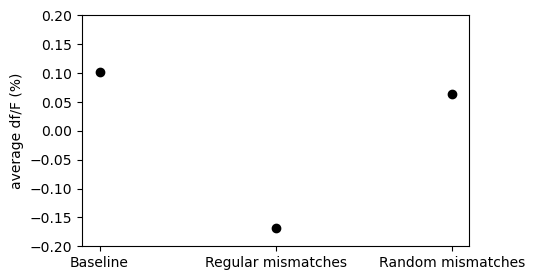

In [60]:
plt.figure(figsize=(5,3))

plt.scatter(0,block1_average_dfF, c='black')
# plt.errorbar(0, block1_average_dfF, yerr=block1_std_dfF, capsize=5, c='black')

plt.scatter(1,block2_average_dfF, c='black')
# plt.errorbar(1, block2_average_dfF, yerr=block2_std_dfF, capsize=5, c='black')

plt.scatter(2,block3_average_dfF, c='black')
# plt.errorbar(2, block3_average_dfF, yerr=block3_std_dfF, capsize=5, c='black')

plt.xticks([0,1,2], ['Baseline', 'Regular mismatches', 'Random mismatches'])
plt.ylabel('average df/F (%)')

plt.ylim([-0.2, 0.2])

plt.show()

## perievent analysis

In [61]:
temp_data = preprocessed_csv[preprocessed_csv['HARP Seconds'].between(A, B)][['HARP Seconds','470_dfF']]
get_perievent_trace(temp_data, 'HARP Seconds', halt_times[0])

,HARP Seconds,470_dfF
13104,354644.741386,0.202036
13105,354644.841375,0.218643
13106,354644.941362,0.233733
13107,354645.041345,0.247507
13108,354645.141332,0.260183
...,...,...
13209,354655.240152,0.432072
13210,354655.340142,0.433918
13211,354655.440126,0.435929
13212,354655.540116,0.439229


In [62]:
running_unit_conversion(streams['H1']['OpticalTrackingRead0X(46)'])

Time
1904-01-05 02:08:51.190240    5.630333
1904-01-05 02:08:51.200256    5.524500
1904-01-05 02:08:51.210240    5.185833
1904-01-05 02:08:51.220256    4.699000
1904-01-05 02:08:51.230240    4.656667
                                ...   
1904-01-05 02:40:37.390240    3.090333
1904-01-05 02:40:37.400256    2.772833
1904-01-05 02:40:37.410240    2.899833
1904-01-05 02:40:37.420256    3.090333
1904-01-05 02:40:37.430240    3.238500
Name: OpticalTrackingRead0X, Length: 190625, dtype: float64

In [63]:
moving_average_smoothing(running_unit_conversion(streams['H1']['OpticalTrackingRead0X(46)']), 100).shape

(190625,)

In [64]:
running_unit_conversion(streams['H1']['OpticalTrackingRead0X(46)']).rolling(5).sum()

Time
1904-01-05 02:08:51.190240          NaN
1904-01-05 02:08:51.200256          NaN
1904-01-05 02:08:51.210240          NaN
1904-01-05 02:08:51.220256          NaN
1904-01-05 02:08:51.230240    25.696333
                                ...    
1904-01-05 02:40:37.390240    18.944167
1904-01-05 02:40:37.400256    17.039167
1904-01-05 02:40:37.410240    15.853833
1904-01-05 02:40:37.420256    15.240000
1904-01-05 02:40:37.430240    15.091833
Name: OpticalTrackingRead0X, Length: 190625, dtype: float64

In [65]:
# all_running = moving_average_smoothing(running_unit_conversion(streams['H1']['OpticalTrackingRead0X(46)']), 100)
# all_running = running_unit_conversion(streams['H1']['OpticalTrackingRead0X(46)']).apply(lambda x: moving_average_smoothing(x, 100))
all_running = running_unit_conversion(streams['H1']['OpticalTrackingRead0X(46)'])

In [68]:
before_event_period=5
during_event_period=1
after_event_period=5

photometry_chunks = []
running_chunks = []

for halt_time in halt_times:
    
    # Select chunk
    photometry_chunk = get_perievent_trace(temp_data, 'HARP Seconds', halt_time)
    start = process.convert_seconds_to_datetime(halt_time - before_event_period)
    end = process.convert_seconds_to_datetime(halt_time + during_event_period + after_event_period)
    running_chunk = all_running.loc[start:end]
    running_times = (running_chunk.index - utils.harp.REFERENCE_EPOCH).total_seconds()
    
    start = halt_time - before_event_period
#     start = halt_time - 1
    end = halt_time
    photometry_F0 = select_segment(photometry_chunk, 'HARP Seconds', start, end)['470_dfF'].mean()
    running_F0 = running_chunk.loc[process.convert_seconds_to_datetime(start):process.convert_seconds_to_datetime(end)].mean()
    
    photometry_chunk = dfF(photometry_chunk, photometry_F0)
    running_chunk = dfF(running_chunk, running_F0)
    
    photometry_chunks.append(photometry_chunk['470_dfF'].values)
    running_chunks.append(running_chunk.values)

photometry_chunks = np.array(photometry_chunks)
running_chunks = np.array(running_chunks)
print(photometry_chunks.shape, running_chunks.shape)

average_photometry_chunk = photometry_chunks.mean(axis=0)
average_running_chunk = running_chunks.mean(axis=0)

(19, 110) (19, 1100)


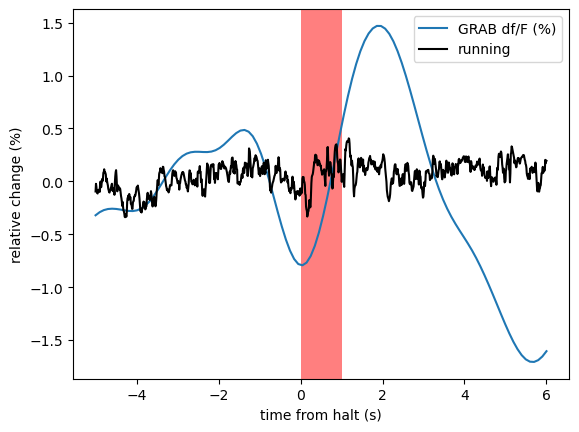

In [69]:
photometry_t = np.linspace(-before_event_period, during_event_period + after_event_period, average_photometry_chunk.shape[0])
running_t = np.linspace(-before_event_period, during_event_period + after_event_period, average_running_chunk.shape[0])

plt.plot(photometry_t, average_photometry_chunk, label='GRAB df/F (%)')
plt.plot(running_t, average_running_chunk, c='black', label='running')
# plt.axvline(0, c='r', alpha=0.5)

plt.gca().add_patch(patches.Rectangle((0, plt.gca().get_ylim()[0]), 1, plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0], edgecolor='none',facecolor='red', alpha=0.5))

plt.xlabel('time from halt (s)')
plt.ylabel('relative change (%)')

plt.legend()

plt.show()